<a href="https://colab.research.google.com/github/handsomecoderyang/deep-learning-for-image-processing/blob/master/%E2%80%9Ccovid_19%20regression%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
%cd './drive/MyDrive/ML2021'

[Errno 2] No such file or directory: './drive/MyDrive/ML2021'
/content/drive/MyDrive/ML2021


In [119]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/drive/My Drive/ML2021/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 42.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/drive/MyDrive/ML2021/covid.test.csv
100% 651k/651k [00:00<00:00, 20.6MB/s]


In [175]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# 数据准备部分
import numpy as np
import csv
import os
# 绘图部分
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069 #设置一个随机数种子
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed)

In [173]:
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()




In [151]:
class MyDataSet(Dataset):
  def __init__(self, path, mode='train', target_only=False):
    self.mode = mode
    with open(path, 'r') as fp:
      data = csv.reader(fp)
      data = list(data)
      data = np.array(data)
      # print(data)
      data = data[1:][:,1:].astype(float)
      # print(data)
    if mode == 'test':
      data = data[:, :-1]
      data = torch.FloatTensor(data)
    else:
      target = data[:, -1]
      data = data[:, :-1]
      if mode == 'train':
        indices = [indice for indice in range(len(data)) if indice %10 != 0]
      elif mode == 'dev':
        indices = [indice for indice in range(len(data)) if indice %10 == 0]
      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])
    self.dim = self.data.shape[1]
    self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) / self.data[:, 40:].std(dim=0, keepdim=True)
  def __getitem__(self, index):
    if self.mode in ['train', 'dev']:
      return self.data[index], self.target[index]
    else:
      return self.data[index]
  def __len__(self):
    return len(self.data)

In [145]:
def pre_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
  # 将数据集放入一个装载器中
  dataset = MyDataSet(path, mode=mode, target_only=target_only)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=(mode=='train'),
                          num_workers=n_jobs, drop_last=False, pin_memory=True)
  # print("finished loading the {} dataset of covid_19( {} samples found, each dim= {} )".format(len(dataset), dataloader.dataset.size()[1]))
  return dataloader


In [170]:
from torch.nn.modules.activation import ReLU
class NeuralNetwork(nn.Module):
  def __init__(self, input_dim):
    super(NeuralNetwork, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )
    self.criterion = nn.MSELoss(reduction='mean')

  def forward(self, input):
    return self.net(input).squeeze()

  def cal_loss(self, pred, target):
    return self.criterion(pred, target)

In [157]:
def train(train_set, validation_set, model, config, device):
  n_epochs = config['n_epochs'] #迭代的轮回
  optimizier = getattr(torch.optim, config['optimizier'])(model.parameters(), **config['optim_hparas'])
  min_mse = 1000.
  loss_record = {'train': [], 'dev': []}
  early_stop_cnt = 0
  epoch = 0
  while epoch < n_epochs:
    model.train()
    for data, target in train_set:
      data, target = data.to(device), target.to(device)
      optimizier.zero_grad()
      result = model(data)
      mse_loss = model.cal_loss(result, target)
      mse_loss.backward()
      optimizier.step()
      loss_record['train'].append(mse_loss.detach().cpu().item())
    dev_mse = dev(validation_set, model, device)
    if dev_mse < min_mse:
      min_mse = dev_mse
      print("Saving model: epoch: {:4d}, loss: {:.4f}".format(epoch+1, min_mse))
      torch.save(model.state_dict(), config['path'])
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1
    epoch += 1
    loss_record['dev'].append(dev_mse.detach().cpu().item())
    if early_stop_cnt > config['early_stop']:
      break
  print("Finished training after {} epochs".format(epoch))
  return min_mse, loss_record

In [160]:
def dev(dv_set, model, device):
  model.eval()
  total_loss = 0
  for data, target in dv_set:
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
      pred = model(data)
      mse_loss = model.cal_loss(pred, target)
    total_loss += mse_loss
  total_loss /= len(dv_set.dataset)
  
  return total_loss

In [162]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizier': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'path': 'models/model.pth'  # your model will be saved here
}

In [152]:
tr_set = pre_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = pre_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
# tt_set = pre_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)
tr_set.dataset.dim

93

Saving model: epoch:    1, loss: 0.2920
Saving model: epoch:    2, loss: 0.1393
Saving model: epoch:    3, loss: 0.0967
Saving model: epoch:    4, loss: 0.0599
Saving model: epoch:    5, loss: 0.0360
Saving model: epoch:    6, loss: 0.0236
Saving model: epoch:    7, loss: 0.0192
Saving model: epoch:    8, loss: 0.0164
Saving model: epoch:    9, loss: 0.0141
Saving model: epoch:   10, loss: 0.0125
Saving model: epoch:   11, loss: 0.0115
Saving model: epoch:   12, loss: 0.0104
Saving model: epoch:   13, loss: 0.0097
Saving model: epoch:   14, loss: 0.0091
Saving model: epoch:   15, loss: 0.0085
Saving model: epoch:   16, loss: 0.0081
Saving model: epoch:   17, loss: 0.0076
Saving model: epoch:   18, loss: 0.0072
Saving model: epoch:   19, loss: 0.0070
Saving model: epoch:   20, loss: 0.0066
Saving model: epoch:   21, loss: 0.0064
Saving model: epoch:   22, loss: 0.0061
Saving model: epoch:   23, loss: 0.0059
Saving model: epoch:   24, loss: 0.0058
Saving model: epoch:   25, loss: 0.0056


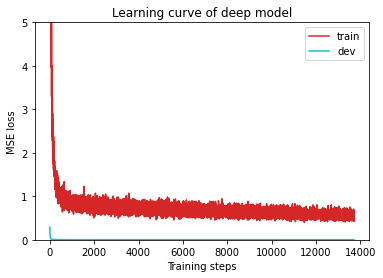

In [177]:
model = NeuralNetwork(tr_set.dataset.dim).to(device)
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)
print(model_loss, model_loss_record)
plot_learning_curve(model_loss_record, title='deep model')

In [130]:
mypath = "covid.train.csv"
dataset = MyDataSet(path=mypath)
len(dataset)
dataloader = pre_dataloader(mypath, 'train', 8, 2)
len(dataloader)
dataset[0]
# for index, i in enumerate(dataloader):
#  if index == len(dataloader)-1:
#    print(i)
# dataset[0].size()
# dataset[0]
# dataset.data[0]

# dataset.data.size()
# model = NeuralNetwork(dataset.data.size()[1])
# model(dataset.data[0])

In [15]:
path = "covid.train.csv"
with open(path, 'r') as fp:
  data = csv.reader(fp)
  data = list(data)
  data = np.array(data)
  # print(data)
  data = data[1:][:,1:].astype(float)
  print(data)
  data[:, -1]

[[ 1.         0.         0.        ... 53.9915494 43.6042293 20.7049346]
 [ 1.         0.         0.        ... 54.185521  42.6657659 21.2929114]
 [ 1.         0.         0.        ... 53.6370693 42.972417  21.1666563]
 ...
 [ 0.         0.         0.        ... 67.731162  38.740651  12.6134414]
 [ 0.         0.         0.        ... 67.7950996 38.595125  12.4772268]
 [ 0.         0.         0.        ... 68.2840782 38.4538196 11.8117187]]
